In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import torch
import yaml
from argparse import Namespace
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from model import get_model_and_optim
from data import prepare_nuclear_data
import seaborn as sns
import pandas as pd
sns.set()

# Download required files from Zenodo
wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar

tar -xvf nuclr_files.tar

rm nuclr_files.tar

Now you should have three folders: `checkpoints/`, `data/` and `plots`. 

In [2]:
# !wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar
# !tar -xvf nuclr_files.tar
# !rm nuclr_files.tar

# Load data and model

In [3]:
# load args from disk
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open("checkpoints/args.yaml", "r") as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
    # TODO fix this. args were saved in the wrong order, so we need to fix them
    args["TARGETS_REGRESSION"] = {
        "binding_semf": 1,
        "z": 1,
        "n": 1,
        "radius": 1,
        "qa": 1,
        "qbm": 1,
        "qbm_n": 1,
        "qec": 1,
        "sn": 1,
        "sp": 1,
    }

args["DEV"] = device
args = Namespace(**args)
print("Loaded args:", args, "\n")

data = prepare_nuclear_data(args)
print("Loaded Data:", data._fields, "\n")
model_final = torch.load("checkpoints/fig1_model.pt", map_location=device).state_dict()
model, _ = get_model_and_optim(data, args)
# model.load_state_dict(torch.load("checkpoints/fig1_model_16.pt", map_location=device))
model.load_state_dict(model_final)

Loaded args: Namespace(BATCH_SIZE=1024, CKPT_FREQ=10, CLIP_GRAD=0.001, DEPTH=2, DEV=device(type='cpu'), EPOCHS=50000, HIDDEN_DIM=2048, HOLDOUT='false', LIPSCHITZ='false', LOG_FREQ=1, LR=0.0001, MODEL='baseline', READOUT='identity', ROOT='/work/submit/kitouni/ai-nuclear', SCHED='cosine', SEED=0, SIGMOID_READOUT='false', START_FROM='none', TARGETS_CLASSIFICATION={}, TARGETS_REGRESSION={'binding_semf': 1, 'z': 1, 'n': 1, 'radius': 1, 'qa': 1, 'qbm': 1, 'qbm_n': 1, 'qec': 1, 'sn': 1, 'sp': 1}, TMS='remove', TRAIN_FRAC=0.9, WANDB=False, WD=0.01, basedir='/work/submit/kitouni/ai-nuclear/FULL/model_baseline/wd_0.01/lr_0.0001/epochs_50000/trainfrac_0.9/hiddendim_2048/depth_2/seed_0/batchsize_1024/targetsclassification_None/targetsregression_binding_semf:1-z:1-n:1-radius:1-qa:1-qbm:1-qbm_n:1-qec:1-sn:1-sp:1/sched_cosine/lipschitz_false') 

Loaded Data: ('X', 'y', 'vocab_size', 'output_map', 'regression_transformer', 'train_mask', 'val_mask') 



<All keys matched successfully>

Let's take a quick look at the first 2 PCs of the Z embedding matrix (model.emb0)

PCA: [0.19690894 0.0322329  0.01783664 0.01374839 0.01251921 0.01116619
 0.00998194 0.0098461  0.00942046 0.00917775] 



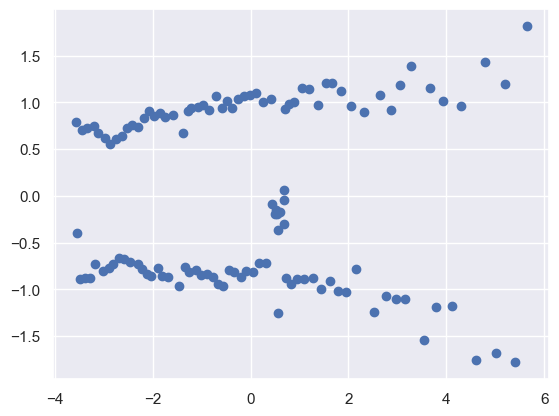

PCA: [0.16042013 0.02765169 0.0202575  0.01639943 0.01194351 0.00872837
 0.00763867 0.00730084 0.00693547 0.00683842] 



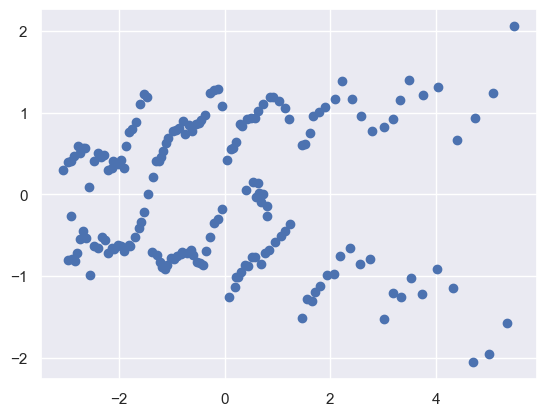

In [19]:
for nucleon_type, nucleon_type_name in enumerate(["z", "n"]):
    pca = PCA(n_components=10)
    embs = pca.fit_transform(model.emb[nucleon_type].detach().cpu().numpy())
    df = pd.DataFrame(data=embs, columns=[f"PC{i+1}" for i in range(10)])
    df[nucleon_type_name] = list(range(data.vocab_size[nucleon_type]))
    df.to_csv(f"streamlit-data/{nucleon_type_name}_pca.csv", index=False)

    print("PCA:", pca.explained_variance_ratio_, "\n")
    plt.plot(embs[:, 0], embs[:, 1], "o")
    plt.show()

Now, I'm going to do a simple analysis to see how the model predictions changes as I keep Z fixed and vary N.

In [5]:
task_names = list(data.output_map.keys())   # get a list of names of tasks (e.g. binding_semf)
magic_numbers = [2, 8, 20, 28, 50, 82, 126][1::]
# keep Z fixed and change N see how BE changes.
task_name = "binding_semf"
task_idx = task_names.index(task_name)
protons = 82
max_neutrons = 130
inputs = torch.full((max_neutrons - 9, 3), protons) # 9 is the minimum number of neutrons
inputs[:, 1] = torch.arange(9, max_neutrons) # change the number of neutrons
inputs[:, 2] = task_idx # change the task index
preds = model(inputs)
preds = preds[:, task_idx].cpu().detach() # get the predictions for the task

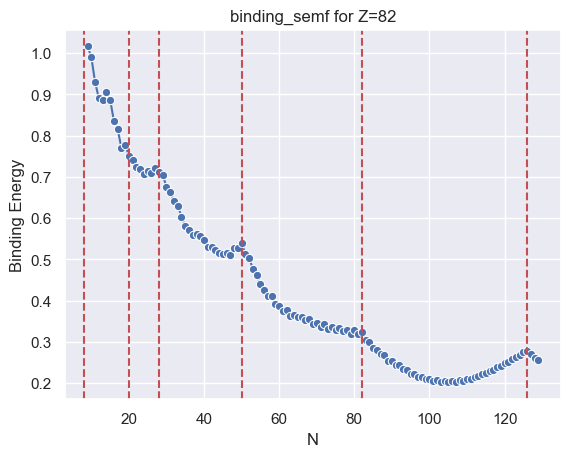

In [6]:
sns.lineplot(x=inputs[:, 1], y=preds, marker='o')
for magic_number in magic_numbers:
    plt.axvline(magic_number, color='r', linestyle='--')
plt.xlabel("N")
plt.ylabel("Binding Energy")
plt.title(f"{task_name} for Z={protons}")
plt.savefig(f"plots/Z_{protons}_{task_name}.pdf", bbox_inches='tight', pad_inches=0)

Now, let's take a look at how the model predictions compare to the data.

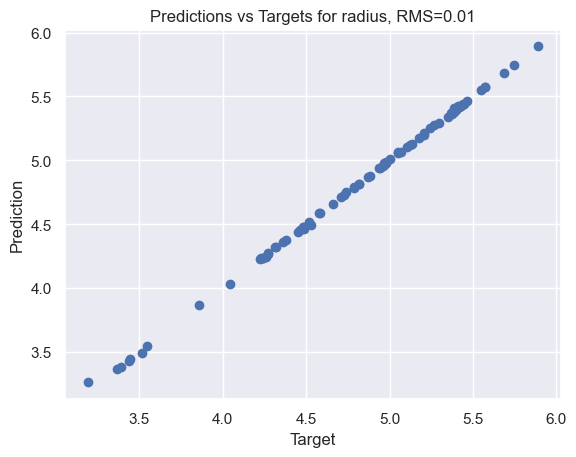

RMS: 0.01


In [7]:
def preds_targets_zn(task_name, train=True):
    # the data has an admittedly weird structure
    # data.X is a tensor of shape (N, 3) where N is the number of nuclei
    # TIMES the number of tasks. The first column is the number of protons,
    # the second column is the number of neutrons, and the third column is
    # the task index. 
    mask = data.train_mask if train else data.val_mask
    task_idx = task_names.index(task_name)
    X_train = data.X[mask]
    scatter = X_train[:, 2].cpu().numpy() == task_idx # get only rows relevant to task

    # get the targets and predictions for the task
    # first, we need to undo the preprocessing
    # data.regresion_transformer is a sklearn transformer that does the preprocessing
    # we can use its inverse_transform method to undo the preprocessing
    # it expects a numpy array, of shape (samples, features) where features is the number
    # of tasks we have.
    targets = data.y.view(-1, 10).cpu().numpy()
    targets = data.regression_transformer.inverse_transform(targets)
    targets = targets.flatten()[mask.cpu().numpy()]
    targets = targets[scatter]

    # Predictions on the other hand are shape (samples, tasks)
    # each row has one correct prediction, and the rest are not useful
    # this is not optimal but not worth optimizing for now
    preds = model(data.X[mask])
    preds = preds.cpu().detach().numpy()
    preds = data.regression_transformer.inverse_transform(preds)[scatter, task_idx]
    return preds, targets, X_train[scatter, :2].cpu().numpy()


def plot_predictions(task_name, train=True):
    preds, targets, zn = preds_targets_zn(task_name, train)

    non_nan_targets = ~np.isnan(targets)
    targets = targets[non_nan_targets]
    preds = preds[non_nan_targets]

    rms = np.sqrt(np.mean((preds - targets)**2))

    plt.plot(targets, preds, "o")
    plt.xlabel("Target")
    plt.ylabel("Prediction")
    plt.title(f"Predictions vs Targets for {task_name}, RMS={rms:.2f}")
    plt.show()
    print(f"RMS: {rms:.2f}")
    
plot_predictions("radius", train=False)

## Reverting Back to Binding Energies
Let's convert the model predictions to actual binding energies in keV. The model we trained predicts differences from the semi-empirical mass formula (SEMF) binding energies. So, we need to add the SEMF binding energies back to the model predictions to get the actual binding energies.

In [8]:
from data import get_nuclear_data, get_targets, semi_empirical_mass_formula
import pandas as pd 


zn = data.X[::len(data.output_map), :2].cpu().numpy()
y_orig = data.regression_transformer.inverse_transform(data.y.view(-1, len(data.output_map)).cpu().numpy())

df_data = np.concatenate([zn, y_orig], axis=1)
df_data = pd.DataFrame(df_data, columns=["Z", "N"]+task_names)
df_data["binding"] = semi_empirical_mass_formula(df_data["Z"], df_data["N"]) + df_data["binding_semf"]
df_data.head()

,Z,N,binding_semf,z,n,radius,qa,qbm,qbm_n,qec,sn,sp,binding
0,9.0,9.0,-94.804138,9.0,9.000000,NaN,-4415.221191,-4444.505859,-23698.658203,1655.928345,9149.907227,5607.094727,7631.638295
1,9.0,10.0,-224.958405,9.0,10.000000,2.8976,-4013.798828,-3239.498291,-14876.380859,-4820.303711,10431.875977,7993.599609,7779.019195
2,9.0,11.0,-167.327927,9.0,11.000000,NaN,-8126.286133,7024.470703,-9840.835938,-3813.634766,6601.335938,10639.291992,7720.135103
3,9.0,12.0,-192.668701,9.0,12.000000,NaN,-10342.599609,5684.170410,-1076.991821,-8109.638672,8101.459961,11132.748047,7738.293393
4,9.0,13.0,-50.938557,9.0,13.000001,NaN,-12744.707031,10818.090820,453.832184,-6489.656738,5230.336914,12557.628906,7624.295398


We can use the `preds_targets_zn` function to convert a specifc key to its original units. The function returns converted predictions, targets and the corresponding N and Z values.

In [9]:
preds, targets, zn = preds_targets_zn("binding_semf", train=True)
preds += semi_empirical_mass_formula(zn[:, 0], zn[:, 1])
targets += semi_empirical_mass_formula(zn[:, 0], zn[:, 1])

df_train = np.concatenate((zn, preds.reshape(-1, 1), targets.reshape(-1, 1)), axis=1)
df_train = pd.DataFrame(df_train, columns=["Z", "N", "pred", "target"])
df_train.head()

,Z,N,pred,target
0,9.0,9.0,7632.098145,7631.638184
1,9.0,10.0,7779.609375,7779.019043
2,9.0,11.0,7720.568848,7720.135254
3,9.0,12.0,7739.153809,7738.293457
4,9.0,13.0,7624.506836,7624.295410


In [10]:
preds, targets, zn = preds_targets_zn("binding_semf", train=False)
preds += semi_empirical_mass_formula(zn[:, 0], zn[:, 1])
targets += semi_empirical_mass_formula(zn[:, 0], zn[:, 1])

df_val = np.concatenate((zn, preds.reshape(-1, 1), targets.reshape(-1, 1)), axis=1)
df_val = pd.DataFrame(df_val, columns=["Z", "N", "pred", "target"])
df_val.head()

,Z,N,pred,target
0,10.0,13.0,7949.505371,7955.255859
1,10.0,17.0,7538.881348,7520.415039
2,10.0,24.0,6255.295898,6287.000000
3,11.0,13.0,8043.816895,8063.488281
4,11.0,26.0,6399.410645,6403.000000


## Nuclear Embeddings

Let's take a look at the *nuclear* embeddings *i.e.* the first layer output of the model after combining N, Z, and target embeddings.

In [11]:
for n, p in model.named_parameters():
    print(n, p.shape)

emb.0 torch.Size([119, 2048])
emb.1 torch.Size([179, 2048])
emb.2 torch.Size([10, 2048])
nonlinear.0.weight torch.Size([2048, 6144])
nonlinear.0.bias torch.Size([2048])
nonlinear.2.ff.0.weight torch.Size([2048, 2048])
nonlinear.2.ff.0.bias torch.Size([2048])
nonlinear.2.ff.2.weight torch.Size([2048, 2048])
nonlinear.2.ff.2.bias torch.Size([2048])
nonlinear.3.ff.0.weight torch.Size([2048, 2048])
nonlinear.3.ff.0.bias torch.Size([2048])
nonlinear.3.ff.2.weight torch.Size([2048, 2048])
nonlinear.3.ff.2.bias torch.Size([2048])
readout.weight torch.Size([10, 2048])
readout.bias torch.Size([10])


In [12]:
znt = data.X[data.X[:, 2] == task_names.index("binding_semf")]
znt_np = znt.cpu().detach().numpy()
embs = model.embed_input(znt, model.emb)

PCA: [0.13497615 0.01921206 0.01577241 0.01264597 0.0104593  0.00940313
 0.00914029 0.00833698 0.00794767 0.00767512] 



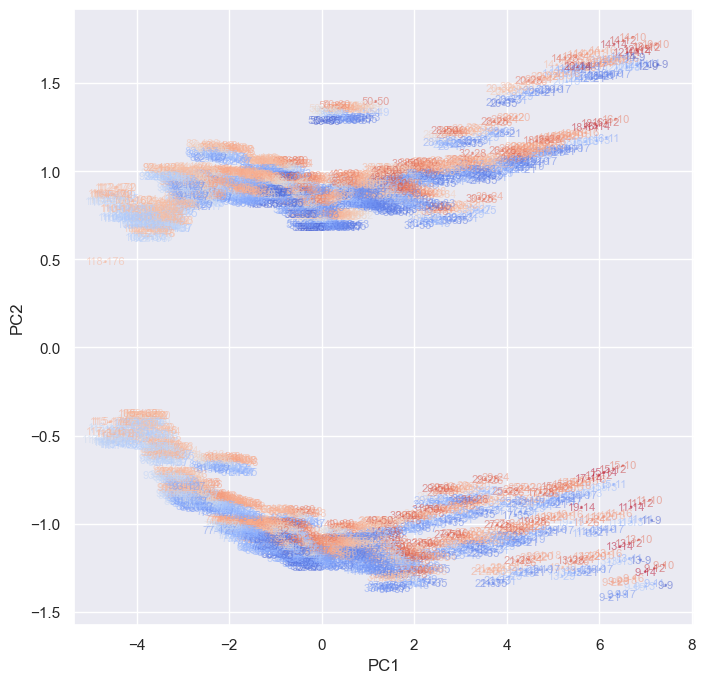

In [13]:
pca = PCA(n_components=10)
embs_pca = pca.fit_transform(embs.detach().cpu().numpy())
print("PCA:", pca.explained_variance_ratio_, "\n")

def scatter_2d_nuclei(x_axis_pc, y_axis_pc, color_pc):
    x = embs_pca[:, x_axis_pc]
    y = embs_pca[:, y_axis_pc]
    colors = embs_pca[:, color_pc]
    colors = (colors-min(colors))/(max(colors)-min(colors))
    colors = plt.cm.coolwarm(colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    for idx, coords in enumerate(zip(x, y)):
        zn = znt[idx, :2].cpu().numpy()
        plt.text(coords[0], coords[1], f"{zn[0]}-{zn[1]}", fontsize=8, ha="center", va="center", color=colors[idx], alpha=0.5)
    plt.scatter(x, y, c=colors, alpha=0.5, s=1)

    plt.xlabel(f"PC{x_axis_pc+1}")
    plt.ylabel(f"PC{y_axis_pc+1}")
    # plt.axis("off")
    plt.show()
    
for i in range(1):
    for j in range(i+1, 2):
        scatter_2d_nuclei(i, j, j+1)

# Optional Interactive Plots
This part is completely optional and it makes HTML files that you can use to embed interactive plots on a website.

In [14]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from matplotlib.colors import rgb2hex

In [15]:
# lets remake this plot in plotly
fig = go.Figure()
hover_template = (
    "Z=%{customdata[0]}<br>N=%{customdata[1]}<br>PC1=%{x}<br>PC2=%{y}<extra></extra>"
)
zn = znt[:, :2].cpu().numpy()
x, y = embs_pca[:, :2].T
text = [f"{z}-{n}" for z, n in zn]

colors = embs_pca[:, 2]


fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode="markers",
        marker=dict(color=colors, size=5, colorscale="rdbu"),
        text=[f"{z}-{n}" for z, n in zn],
        textposition="top center",
        textfont=dict(size=8),
        hoverinfo="skip",
        showlegend=False,
        hovertemplate=hover_template,
        customdata=zn,
    )
)

fig.update_layout(
    title="PCA of First Layer Outputs",
    # add x and y axis labels
    xaxis=dict(title="PC1"),
    yaxis=dict(title="PC2"),
    hovermode="closest",
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=1.0,
            y=1.15,
            buttons=[
                dict(
                    label="Show Markers Only",
                    method="update",
                    args=[{"mode": "markers"}],
                ),
                dict(
                    label="Show Markers with Text",
                    method="update",
                    args=[{"mode": "markers+text"}],
                ),
            ],
        )
    ],
)

html_str = pyo.plot(fig, include_plotlyjs="cdn", output_type="div")
with open("plots/plotly_figure2D.html", "w") as f:
    f.write(html_str)
# fig.show()

In [16]:
# lets remake this plot in plotly
fig = go.Figure()
hover_template = (
    "Z=%{customdata[0]}<br>N=%{customdata[1]}<br>PC1=%{x}<br>PC2=%{y}<extra></extra>"
)
zn = znt[:, :2].cpu().numpy()
x, y, z = embs_pca[:, :3].T
text = [f"{z}-{n}" for z, n in zn]

colors = embs_pca[:, 3]
colors = (colors - min(colors)) / (max(colors) - min(colors))
colors = plt.cm.coolwarm(colors)
colors_hex = [rgb2hex(rgba) for rgba in colors]
colors_hex = [rgb2hex(rgba) for rgba in colors]
fig.add_trace(
    go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode="markers",
        marker=dict(
            color=embs_pca[:, 3],
            size=5,
            colorscale="rdbu",
            colorbar=dict(
                title=dict(
                    text="PC4",
                    font=dict(size=12),
                    side="bottom",
                    
                ),
                # rotate the colorbar so that it is horizontal
                # and the text is readable
                orientation="h",
                tickfont=dict(size=10),
                thickness=5,
                len=0.4,
                # x=0.5,
                # y=0.5,
            ),
        ),
        text=[f"{z}-{n}" for z, n in zn],
        textposition="top center",
        textfont=dict(size=8),
        hoverinfo="skip",
        showlegend=False,
        hovertemplate=hover_template,
        customdata=zn,
    )
)

# fig.update_layout(scene_aspectmod÷e='cube')

fig.update_layout(
    title="PCA of First Layer Outputs",
    scene=dict(
        xaxis_title="PC1- Nucleus Size",
        yaxis_title="PC2 - Z parity",
        zaxis_title="PC3- N parity",
    ),
    hovermode="closest",
)

html_str = pyo.plot(fig, include_plotlyjs="cdn", output_type="div")
with open("plots/plotly_figure3D.html", "w") as f:
    f.write(html_str)
# fig.show()

In [17]:
# save the data to disk
df = pd.DataFrame(data=embs_pca, columns=[f"PC{i+1}" for i in range(10)])
df["zn"] = [f"{z}-{n}" for z, n, t in zip(*znt.T)]
df["z"] = znt[:, 0].cpu().numpy()
df["n"] = znt[:, 1].cpu().numpy()
df.to_csv("streamlit-data/nuclear_pca.csv", index=False)